# Бейзлайн для курса "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

Советы:
0. Заполнить аккаунт н Каггл: фото + статус Contributor
1. Сделайте стабильную валидацию
2. Тестируйте 1 изменение за раз
3. Не переусердствуйте с подбором гиперпараметров модели. Делайте это 1 раз вначале и 1 раз в конце
4. Прирост качества в основном зависит от __очистки данных__ и __генерации фич__, а не от модели
5. Бывает полезно удалить "мусорные" фичи. Определить их можно, например, через feature importance

Дедлайны и требования:
- Соревнование заказнчивается 29 апреля
- Необходимо получить R2 > 60% на __Private__ Leaderboard для успешного завершения курса
- Необходимо получить ранг "Contributor" в соревнованиях на Каггле: https://www.kaggle.com/progression
- Прислать в комментариях к ДЗ ссылка на решение проекта в git / public kaggle notebook

Переобучение

1. Большая разница между R2 на train и кросс-валидации
2. Большая разница между R2 на кросс-валидации и Public Leaderbord

In [1]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline

# 1. Чтение данных

In [102]:
df = pd.read_csv('/kaggle/input/realestatepriceprediction/train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('/kaggle/input/realestatepriceprediction/test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  
#df.keys()

Строк в трейне: 10000
Строк в тесте 5000


0

In [101]:
X.head()


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [105]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

## 1. Минимальный EDA

Делаем EDA не просто так, а для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

### 1.1 Выбросы

In [5]:
X.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

**Rooms**

In [ ]:
X['Rooms'].value_counts()

# > 6 комнат, = 0 комнат

In [ ]:
X['KitchenSquare'].value_counts().sort_values()

# Площадь < 3
# Площадь > 100
# Площадь > 1000

In [ ]:
X.loc[X['KitchenSquare'] > 100]

**Floor, HouseFloor**

In [ ]:
X['HouseFloor'].sort_values().unique()

In [ ]:
X['Floor'].sort_values().unique()

In [ ]:
X['HouseFloor'] = X['HouseFloor'].astype(int)
#(X['Floor'] > X['HouseFloor']).sum()
X.groupby([X['Floor'] > X['HouseFloor']]).agg(['count'])

**HouseYear**

In [ ]:
X['HouseYear'].sort_values().unique()

In [ ]:
X[X['HouseYear'] > 2020].head()

### Заполнение NaN

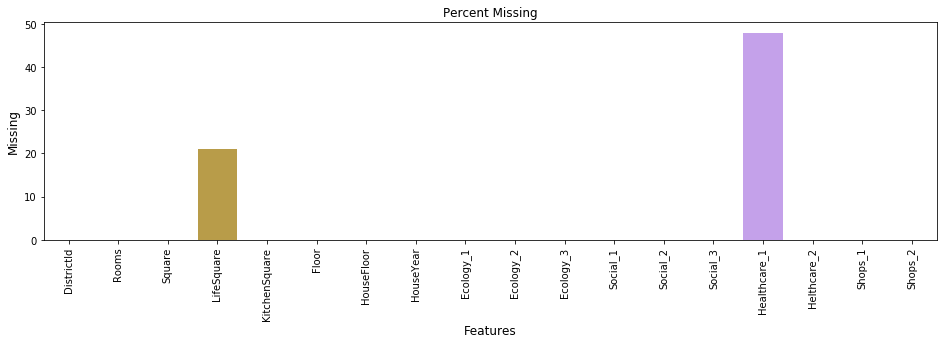

In [106]:
import seaborn as sns

nan_df = (100*(X.isna().sum()) / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare - udalim

### 1.2 Feature engineering

**DistrictId**

In [ ]:
X.DistrictId.nunique()

In [ ]:
dict(X['DistrictId'].value_counts())

# 2. Очистка данных

In [107]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X['Rooms'].fillna(0, inplace = True)
        
        X.loc[(X['Rooms'] <= 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[X['Rooms'] <= 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 6, 'Rooms'] = 6
                        
       
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X['HouseFloor'].fillna(0, inplace = True)
        
        condition = ((X['HouseFloor'] <= 0) | (X['HouseFloor'] > 80))
        X.loc[condition, 'HouseFloor_outlier'] = 1
        
        X['Floor_outlier'] = 0
        X['Floor'].fillna(0, inplace = True)
        condition = ((X['Floor'] <= 0) | (X['Floor'] > 80))
        X.loc[condition, 'Floor_outlier'] = 1
                
        X.loc[X['HouseFloor'] <= 0, 'HouseFloor'] = 1
        X.loc[X['HouseFloor'] > 80, 'HouseFloor'] = 80
        
        X.loc[X['Floor'] <= 0, 'Floor'] = 1
        X.loc[X['Floor'] > 80, 'Floor'] = 80
        
        condition = (X['Floor'] > X['HouseFloor'])
        X.loc[condition, 'Floor_outlier'] = 1
        X.loc[condition, 'Floor'] = X.loc[condition, 'HouseFloor']
                
        # HouseYear
        X['HouseYear_outlier'] = 0
        X['HouseFloor'].fillna(0, inplace = True)
        current_year = datetime.datetime.now().year
        
        X.loc[X['HouseYear'] < 1910, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] < 1910, 'HouseYear'] = 1910
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # All squares
        X['Square'].fillna(0, inplace = True)
        X['KitchenSquare'].fillna(0, inplace = True)
        X['LifeSquare'].fillna(0, inplace = True)
        
        # KitchenSquare
        X['KitchenSquare_outlier'] = 0
        X.loc[(X['KitchenSquare'] < 3) | (X['KitchenSquare'] >= 100), 'KitchenSquare_outlier'] = 1
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        condition = (X['KitchenSquare'] > 100)
        X.loc[condition, 'KitchenSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'LifeSquare']
        
        # Square
        X['Square_outlier'] = 0
        
        condition = (X['Square'] == 0)
        X.loc[condition, 'Square_outlier'] = 1
        X.loc[condition, 'Square'] = X.loc[condition, 'Rooms'] * 25 + X.loc[condition, 'KitchenSquare']
        
        # Square min-max
        X.loc[(X['Square'] < 13) | (X['Square'] >= 800), 'Square_outlier'] = 1
        X.loc[X['Square'] < 13, 'Square'] = 13
        X.loc[X['Square'] > 800, 'Square'] = 800
        
        # LifeSquare
        X['LifeSquare_outlier'] = 0
        condition = (X['LifeSquare'] == 0)
        X.loc[condition, 'LifeSquare_outlier'] = 1
        X.loc[condition, 'LifeSquare'] =  X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare']
        
        # LifeSquare min-max
        X.loc[(X['LifeSquare'] < 13) | (X['LifeSquare'] >= 800), 'LifeSquare_outlier'] = 1
        X.loc[X['LifeSquare'] < 13, 'LifeSquare'] = 13
        X.loc[X['LifeSquare'] > 800, 'KitchenSquare'] = 800
        
        condition = (X['KitchenSquare'] > X['Square'])
        X.loc[condition, 'KitchenSquare_outlier'] = 1
        X.loc[condition, 'KitchenSquare'] = X.loc[condition, 'Rooms'] * 3
       
          
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
                
        return X

In [108]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)


# 3. Feature engineering

In [110]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.med_house_year_by_district = None
        self.med_social_by_district = None
        self.med_ecology_by_district = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        df = X.copy()
        
        # popular district
        df['DistrictId_popular'] = df['DistrictId'].copy()
        df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
        
        self.med_social_by_district = df.groupby(['DistrictId_popular'], as_index=False).agg({'Social_1':'median'}).\
                                      rename(columns={'Social_1':'MedSocialByDistrict',
                                      'DistrictId_popular': 'DistrictId'})
        
        self.med_house_year_by_district = df.groupby(['DistrictId_popular'], as_index=False).agg({'HouseYear':'median'}).\
                                      rename(columns={'HouseYear':'MedHouseYearByDistrict',
                                      'DistrictId_popular': 'DistrictId'})
        
        self.med_ecology_by_district = df.groupby(['DistrictId_popular'], as_index=False).agg({'Ecology_1':'median'}).\
                                      rename(columns={'Ecology_1':'MedEcologyByDistrict',
                                      'DistrictId_popular': 'DistrictId'})
        
        
        # Target encoding
        ## District
                
        if y is not None:
            df['Price'] = y.values
            
                       
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
          
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            
        if self.med_social_by_district is not None:
            X = X.merge(self.med_social_by_district, on=['DistrictId'], how='left')
            
        if self.med_house_year_by_district is not None:
            X = X.merge(self.med_house_year_by_district, on=['DistrictId'], how='left')
        
        if self.med_ecology_by_district is not None:
            X = X.merge(self.med_ecology_by_district, on=['DistrictId'], how='left')
        
        X['Squ_rooms'] = X['Square'] / X['Rooms']
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
            
    

In [111]:
features = FeatureGenetator()

features.fit(X, y)
features.med_price_by_floor_year
X = features.transform(X)
X_final = features.transform(X_final)


In [112]:
X.head(3)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,DistrictId_count,new_district,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,MedSocialByDistrict,MedHouseYearByDistrict,MedEcologyByDistrict,Squ_rooms
0,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,1,...,5.0,1,3.0,3.0,NaN,182951.411659,NaN,NaN,NaN,23.990781
1,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,1,...,87.0,0,3.0,3.0,300009.450063,182951.411659,36.0,1981.0,0.175055,21.894547
2,53,2.0,44.947953,29.197612,3.0,8.0,12.0,1968,0.049637,1,...,174.0,0,3.0,3.0,263206.223152,182951.411659,34.0,1983.0,0.049637,22.473976


In [114]:
remain_features = ['Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                  'HouseFloor', 'HouseYear',
                   'DistrictId_count',
                  'MedPriceByDistrict',
                  'MedPriceByFloorYear', 'MedSocialByDistrict', 'Squ_rooms',
                  'MedHouseYearByDistrict', 'MedEcologyByDistrict']

X = X[remain_features]
X_final = X_final[remain_features]

# 4. Модель

In [120]:
model = LGBMRegressor('gbdt', 
                             num_leaves=20,
                             max_depth=10,
                             n_estimators=300,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.741 +- 0.017


In [121]:
# Обучаю модель на всем трейне
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=20, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

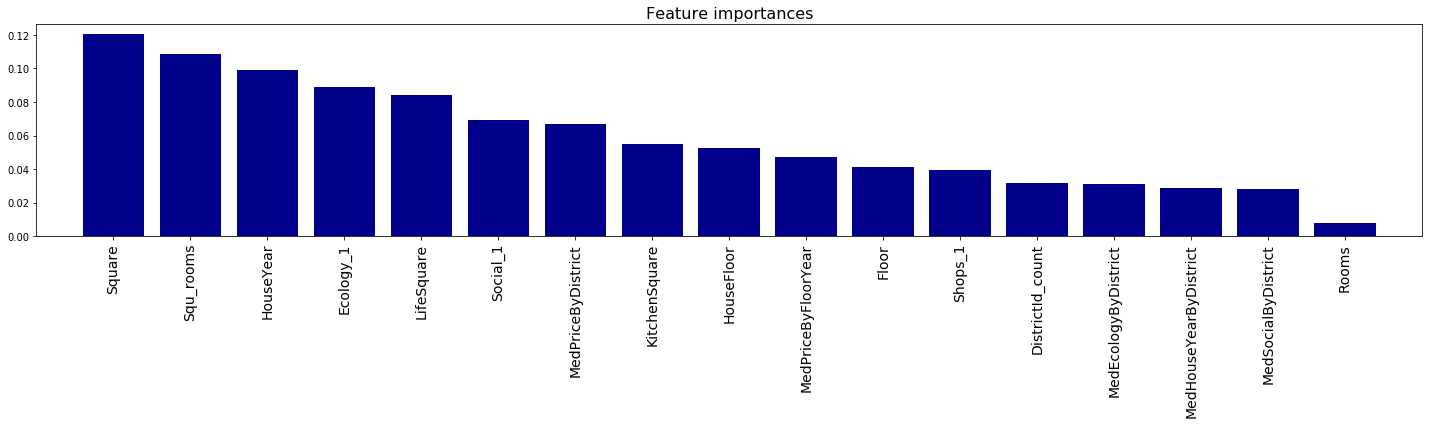

In [122]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [123]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,152469.003230
1,15856,240370.654564
2,5480,179163.750549
3,15664,309708.956506
4,14275,138832.619975


In [79]:
preds_final.shape

(5000, 2)